In [1]:
#Download dependencies before proceeding

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from arboreto.algo import grnboost2

sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

In [4]:
#Read in time-series RNA-seq data

data_df = pd.read_csv('scrna_demo_data.csv')
tf_df = pd.read_csv('Homo_sapiens_TF.csv')
#List of TFs
tfs = set(tf_df['Symbol'].tolist())
#Create transcription factor DF 
#Training can occur on just TFs or with all genes, depending on computational resources.
onlytfs_df = data_df[data_df['Gene'].isin(tfs)]
onlytfs_df = onlytfs_df.set_index('Gene')
onlytfs_df.head()

,T1,T2,T3,T4,T5
Gene,,,,,
ADNP,0.126618,0.502203,-0.080604,-0.001828,0.010267
ADNP2,0.020338,0.428653,-0.062890,-0.007498,-0.117782
AEBP2,-0.141051,0.151103,-0.140975,-0.211942,-0.217800
AFF1,0.337428,-0.125415,-0.187360,-0.055257,-0.118852
AFF2,0.023543,0.000000,0.062551,0.000000,0.000000


In [6]:
#Train network using GRNBoost2

network = grnboost2(expression_data=onlytfs_df.T)
print("Finished traing.")
#Network file
ofile = 'trained_network.csv'
network.to_csv(ofile)
print("Saved network file!")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


Finished
Done


In [7]:
#View Network

network = pd.read_csv(ofile)
network.head()

,Unnamed: 0,TF,target,importance
0,103,DNAJC1,ZBTB1,3.697117
1,457,PREB,NR2F6,3.247254
2,644,ZBED4,SSRP1,3.126304
3,160,FOXO1,ZNF418,3.105024
4,1061,ZNF669,HIVEP1,3.081191


Text(0.5, 0, 'Connection weight (log)')

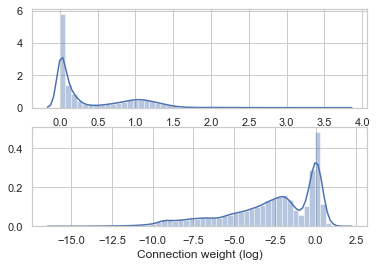

In [8]:
#Visualize edge weight distribution

f, axes = plt.subplots(2, 1)

sns.distplot(a=network['importance'], norm_hist=True, ax=axes[0])
sns.distplot(a=network['importance'].apply(np.log), norm_hist=True, ax=axes[1])

axes[0].set_xlabel('Connection weight')
axes[1].set_xlabel('Connection weight (log)')

In [9]:
#Create graph 

G = nx.from_pandas_edgelist(df=network, source='TF', target='target', edge_attr='importance')

print('Loaded {:,} genes with {:,} edges.'.format(len(G.nodes), len(G.edges)))

Loaded 1,034 genes with 64,173 edges.


In [15]:
#Prune graph

cutoff = 1

print('Removing all edges with weight < {}...\n'.format(cutoff))

bad_edges = [(s,t,w) for (s,t,w) in G.edges.data('importance') if w < cutoff]
G.remove_edges_from(bad_edges)

print('Graph now has {:,} genes and {:,} edges.'.format(len(G.nodes), len(G.edges)))

Removing all edges with weight < 1...

Graph now has 1,127 genes and 12,173 edges.


In [10]:
# Run PageRank
pr = nx.pagerank(G, alpha=0.85, max_iter=50, weight='importance')
#Create dataframe for PageRank values
prdf = pd.DataFrame(pd.Series(pr)).reset_index()
prdf.columns = ['Gene', 'PageRank']
print("Finished")

Finished


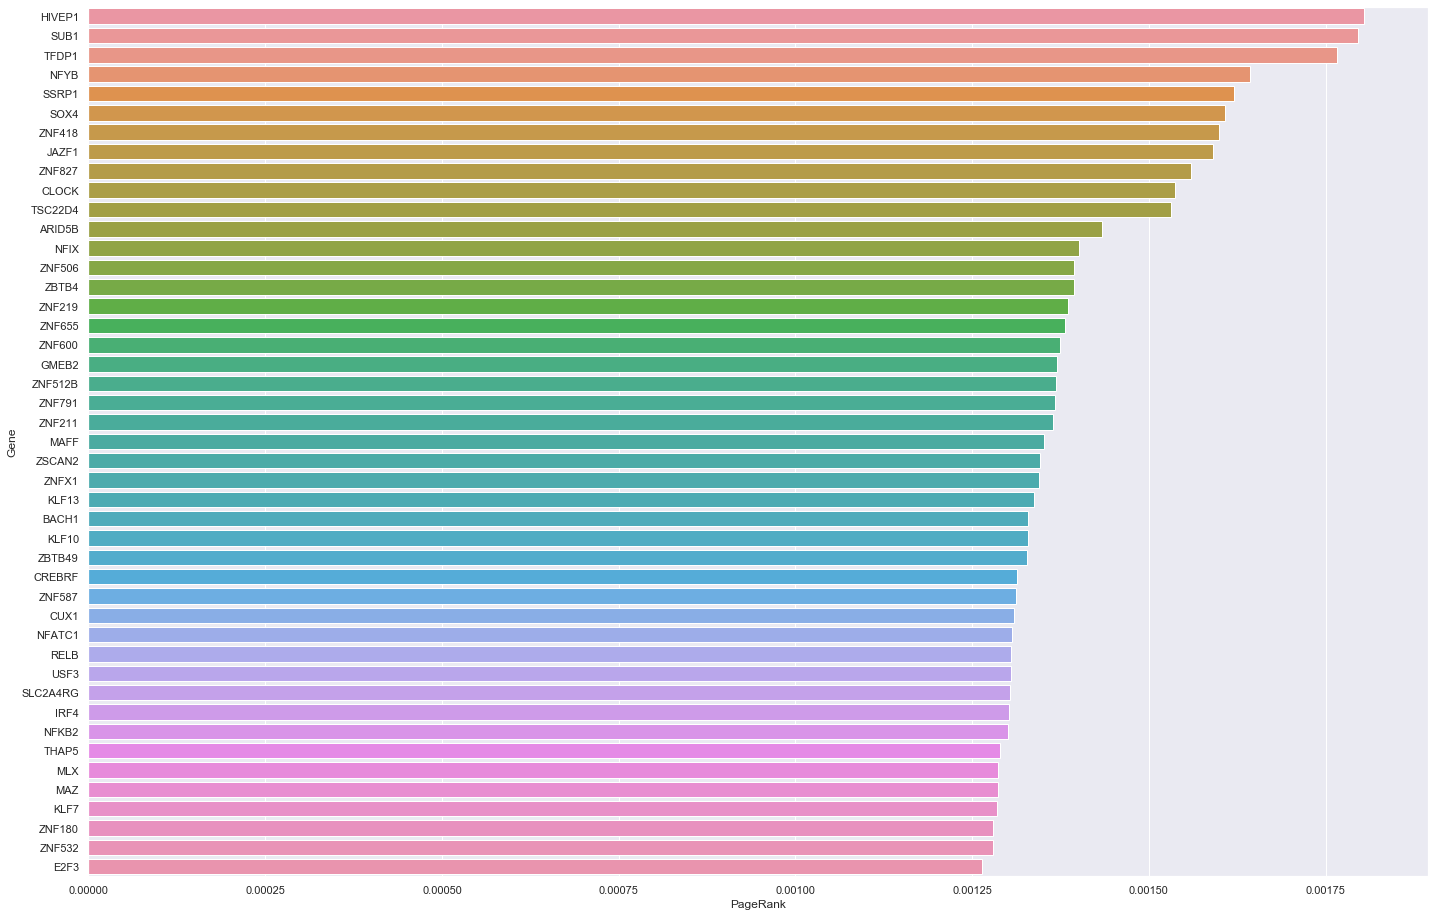

In [11]:
#View top TFs
sns.set(rc={'figure.figsize':(24,16)})
sns.barplot(
    data=prdf.sort_values('PageRank', ascending=False).head(45), 
    x='PageRank', 
    y='Gene'
)
data=prdf.sort_values('PageRank', ascending=False)
#Save ranked TFs
data.to_csv('pageranked_tfs.csv')